# Bayesowskie sieci neuronowe

Na dzisiejszych zajęciach opowiem czym są bayesowskie sieci neuronowe, jak wygląda podejście bayesowskie do głębokiego uczenia i jakimi różnicami charakteryzują się modele bayesowskie. 

Klasyczne uczenie modelu możemy interpretować jako przeprowadzanie Maximum Likelihood Estimation, tj. maksymalizujemy prawdopodobieństwo zaobserwowanych danych uwarunkowane parametrami modelu. Jest to podejście frekwentystyczne. 
Analogicznie w podejściu bayesowskim mówimy o Maximum A Posteriori - mamy jakiś prior, czyli jakąś poprzednią wiedzę, oraz obserwacje. Dzięki twierdzeniu Bayesa możemy uaktualnić nasze przekonania nowymi obserwacjami - otrzymujemy wtedy rozkład posterior. 

_Z perspektywy zatwardziałego statystyka używając jakichkolwiek technik regularyzacji przeprowadzamy MAP, a nie MLE, ponieważ dokładamy już jakąś wiedzę którą mamy o rozkładzie._

Inne źródła opisują uczenie bayesowskie inaczej, np. że mamy po prostu modele których wagi są rozkładami prawdopodobieństwa, w przeciwieństwie do ustalonych wartości (point estimate). Istnieją algorytmy typu Bayes-By-Backprop, które faktycznie pozwalają na wytrenowanie sieci w sposób bardzo zbliżony do tego normalnego, ale nie są jedynymi na które warto zwrócić uwagę, lepiej przyjąć perspektywę uczenia się rozkładu w przestrzeni parametrów, aniżeli jednego optymalnego wektora.

Jak to wygląda w praktyce? Co ciekawe, ucząc sieć bayesowską nie musi być wcale mowy o treningu. Tak jak normalnie, musimy najpierw dobrać odpowiednią do zadania architekturę (functional model w [2]), a poza tym również model stochastyczny, czyli priory. Ten krok można uważać za równoważny dobraniu lossa dla normalnej sieci.

Oznaczmy $\theta$ jako wektor parametrów. Jako priory będziemy musieli dobrać $p(\theta)$ oraz $p(y | x, \theta)$ - bazowy rozkład na przestrzeni parametrów i poziom pewności, że dla obserwacji $x$ i modelu $\theta$ wylądujemy w klasie $y$. 


In [30]:
from copy import deepcopy

import sklearn.model_selection
from sklearn import datasets

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
regular = nn.Sequential(
    nn.Linear(4, 100),
    nn.ReLU(),
    nn.Linear(100, 3),
    nn.LogSoftmax(dim=0)
)

In [3]:
def iris_draw_plots(X, y, predicted):
    fig = plt.figure(figsize = (16, 5))

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    z1_plot = ax1.scatter(X[:, 0], X[:, 1], c = y)
    z2_plot = ax2.scatter(X[:, 0], X[:, 1], c = predicted)

    plt.colorbar(z1_plot,ax=ax1)
    plt.colorbar(z2_plot,ax=ax2)

    ax1.set_title("REAL")
    ax2.set_title("PREDICTED")

    plt.show()



In [4]:

class BayesLinear(nn.Module):
    def __init__(self, prior_mu, prior_sigma, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.prior_mu = torch.tensor(prior_mu)
        self.prior_sigma = torch.tensor(prior_sigma)
        self.prior_log_sigma = torch.log(self.prior_sigma)
        
        self.weight_mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_log_sigma = nn.Parameter(torch.zeros(out_features, in_features))
        self.register_buffer('weight_eps', None)
                
        self.bias_mu = nn.Parameter(torch.zeros(out_features))
        self.bias_log_sigma = nn.Parameter(torch.zeros(out_features))
        self.register_buffer('bias_eps', None)
                        
        self.freeze = False
        self.reset_parameters()

    def reset_parameters(self):
        # Initialization method of Adv-BNN
        stdv = 1. / torch.sqrt(torch.tensor(self.weight_mu.size(1)))
        self.weight_mu.data.uniform_(-stdv, stdv)
        self.weight_log_sigma.data.fill_(self.prior_log_sigma)
        self.bias_mu.data.uniform_(-stdv, stdv)
        self.bias_log_sigma.data.fill_(self.prior_log_sigma)
            
    def forward(self, input):
        if self.freeze:
            pass    #__jm__
        weight = self.weight_mu + torch.exp(self.weight_log_sigma) * torch.randn_like(self.weight_log_sigma)
        bias = self.bias_mu + torch.exp(self.bias_log_sigma) * torch.randn_like(self.bias_log_sigma)

        return F.linear(input, weight, bias)

    def _kl_loss(self, mu_0, log_sigma_0, mu_1, log_sigma_1):
        kl = log_sigma_1 - log_sigma_0 + \
            (torch.exp(log_sigma_0)**2 + (mu_0-mu_1)**2)/(2*torch.exp(log_sigma_1)**2) - 0.5
        return kl.sum()

    def kl_loss(self):
        return self._kl_loss(self.weight_mu, self.weight_log_sigma, self.prior_mu, self.prior_log_sigma) + \
               self._kl_loss(self.bias_mu, self.bias_log_sigma, self.prior_mu, self.prior_log_sigma)

In [5]:
iris = datasets.load_iris()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(iris.data, iris.target, shuffle=True, random_state=42)
X_train, X_test = map(lambda t: torch.from_numpy(t).float(), [X_train, X_test])
y_train, y_test = map(lambda t: torch.from_numpy(t).long(), [y_train, y_test])

In [6]:
bayesian = nn.Sequential(
    BayesLinear(0, 0.1, 4, 100),
    nn.ReLU(),
    BayesLinear(0, 0.1, 100, 3),
    nn.LogSoftmax(dim=0)
)

In [7]:
list(map(torch.numel, bayesian.parameters()))

[400, 400, 100, 100, 300, 300, 3, 3]

In [8]:
train = TensorDataset(X_train, y_train)
dataloader = DataLoader(train, batch_size=8)
optimizer = optim.Adam(regular.parameters(), lr=0.01)

for _step in range(5):
    for X, y in dataloader:
        pre = regular(X)
        loss = F.nll_loss(pre, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    pre = regular(X_test)
    _, predicted = torch.max(pre.data, 1)
    total = y_test.size(0)
    correct = (predicted == y_test).sum()
    print('- Accuracy: %f %%' % (100 * float(correct) / total))



- Accuracy: 92.105263 %
- Accuracy: 94.736842 %
- Accuracy: 94.736842 %
- Accuracy: 94.736842 %
- Accuracy: 97.368421 %


In [9]:
def kl_loss(model):
    return sum(module.kl_loss() for module in model.modules() if hasattr(module, 'kl_loss')) / sum(map(torch.numel, model.parameters()))

In [10]:
train = TensorDataset(X_train, y_train)
dataloader = DataLoader(train, batch_size=8)
optimizer = optim.Adam(bayesian.parameters(), lr=0.01)
kl_weight = len(dataloader)

for _step in range(50):
    for X, y in dataloader:
        pre = bayesian(X)
        _kl_loss = kl_loss(bayesian)
        nll_loss = F.nll_loss(pre, y)
        loss = nll_loss + kl_weight * _kl_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    print(
        f'{_kl_loss.item()=:.6f}',
        f'{nll_loss.item()=:.6f}',
        f'{loss.item()=:.6f}',
    sep=' | ')

    pre = bayesian(X_test)
    _, predicted = torch.max(pre.data, 1)
    total = y_test.size(0)
    correct = (predicted == y_test).sum()
    print('- Accuracy: %f %%' % (100 * float(correct) / total))

_kl_loss.item()=0.585549 | nll_loss.item()=1.659575 | loss.item()=9.857265
- Accuracy: 86.842105 %
_kl_loss.item()=0.191934 | nll_loss.item()=1.691516 | loss.item()=4.378589
- Accuracy: 84.210526 %
_kl_loss.item()=0.054714 | nll_loss.item()=1.944037 | loss.item()=2.710038
- Accuracy: 86.842105 %
_kl_loss.item()=0.018741 | nll_loss.item()=1.952302 | loss.item()=2.214673
- Accuracy: 71.052632 %
_kl_loss.item()=0.012001 | nll_loss.item()=1.964706 | loss.item()=2.132720
- Accuracy: 76.315789 %
_kl_loss.item()=0.009872 | nll_loss.item()=1.939164 | loss.item()=2.077375
- Accuracy: 55.263158 %
_kl_loss.item()=0.008785 | nll_loss.item()=1.939252 | loss.item()=2.062237
- Accuracy: 68.421053 %
_kl_loss.item()=0.008943 | nll_loss.item()=1.955471 | loss.item()=2.080678
- Accuracy: 76.315789 %
_kl_loss.item()=0.009403 | nll_loss.item()=1.984759 | loss.item()=2.116400
- Accuracy: 57.894737 %
_kl_loss.item()=0.010279 | nll_loss.item()=2.044627 | loss.item()=2.188531
- Accuracy: 60.526316 %
_kl_loss.i

In [46]:
regression_model = nn.Sequential(
  BayesLinear(0, 0.1, 1, 20),
  nn.ReLU(),
  BayesLinear(0, 0.1, 20, 20),
  nn.ReLU(),
  BayesLinear(0, 0.1, 20, 1)
)

# regression_model = nn.Sequential(
#   nn.Linear(1, 100),
#   nn.ReLU(),
#   nn.Linear(100, 1)
# )

In [47]:
X_reg = torch.linspace(0, 5, steps=500)
y_reg = torch.sinc(X_reg)

# X_train = torch.cat((X_reg[100:200], X_reg[300:400]))
# y_train = torch.cat((y_reg[100:200], y_reg[300:400]))
X_train = X_reg
y_train = y_reg
y_train += torch.randn_like(y_train) * 0.01

train = TensorDataset(X_train, y_train)
dataloader = DataLoader(train, batch_size=200)

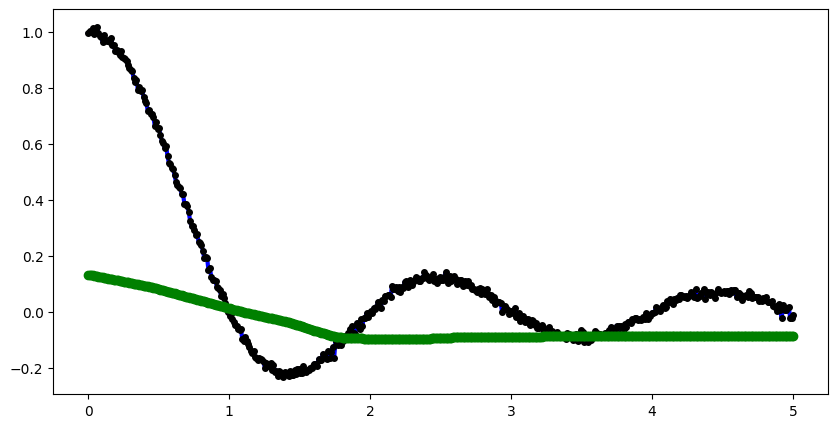

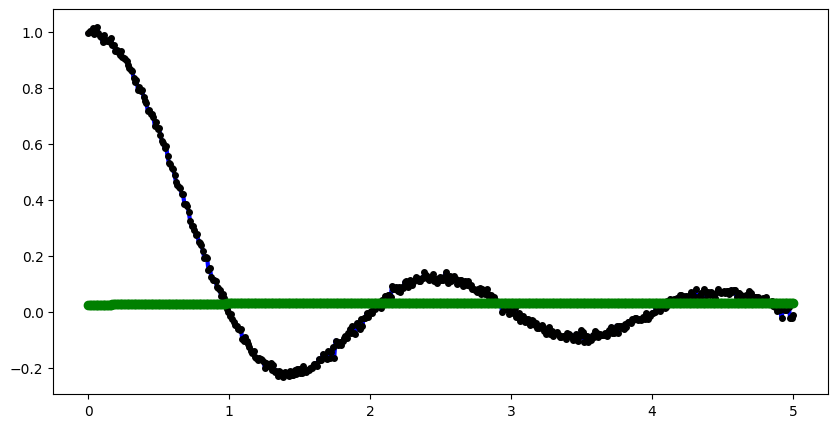

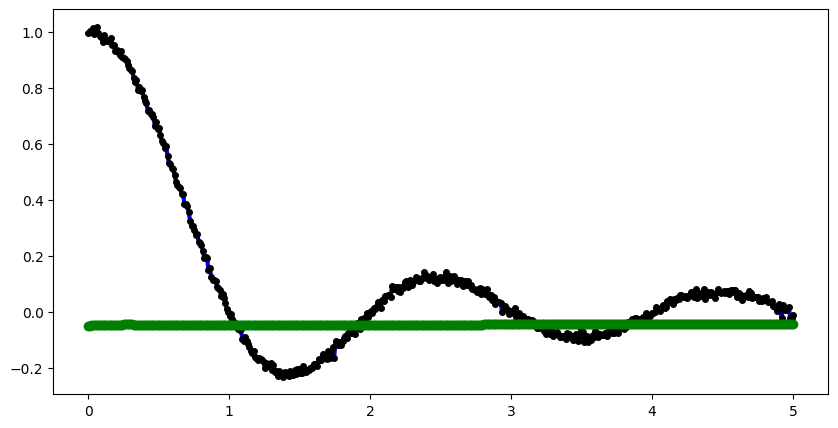

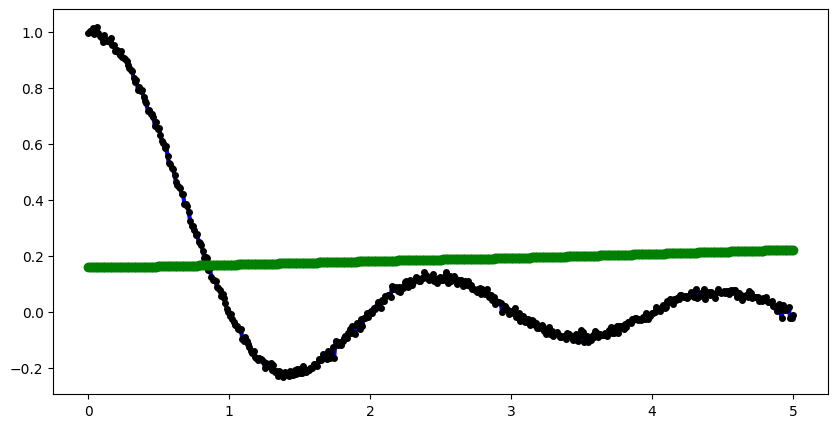

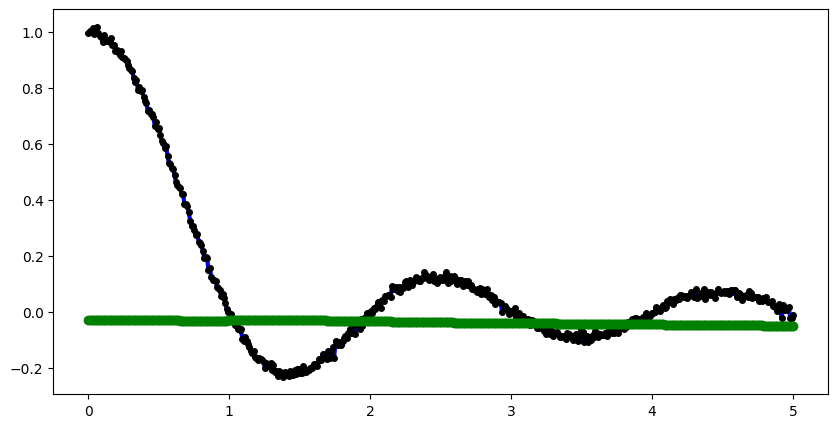

In [48]:
optimizer = optim.Adam(regression_model.parameters(), lr=0.01)
kl_weight = len(dataloader)
mse = nn.MSELoss()
best_model = regression_model
best_loss = float('inf')

for step in range(5000):
    for X, y in dataloader:
        pre = regression_model(X.unsqueeze(1)).squeeze()
        _kl_loss = kl_loss(regression_model)
        mse_loss = mse(pre, y)
        loss = mse_loss + kl_weight * _kl_loss
        
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            optimizer.step()
            if loss < best_loss:
                best_loss = loss
                best_model = deepcopy(regression_model)
    
    # print(
    #     f'{_kl_loss.item()=:.6f}',
    #     f'{mse_loss.item()=:.6f}',
    #     f'{loss.item()=:.6f}',
    # sep=' | ')

    if step % 1000 == 0:
        with torch.no_grad():
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.plot(X_reg, y_reg, 'b-', linewidth=3, label="True function")
            ax.plot(X_train, y_train, 'ko', markersize=4, label="Noisy training data")
            ax.plot(X_reg, best_model(X_reg.unsqueeze(1)), 'go', label="Predictions")
            plt.show()

